In [2]:
import numpy as np, scipy, time
import cg
from pixell import utils, mpi
from scipy.sparse.linalg import cg, LinearOperator
import matplotlib.pyplot as plt
from scipy.signal import welch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

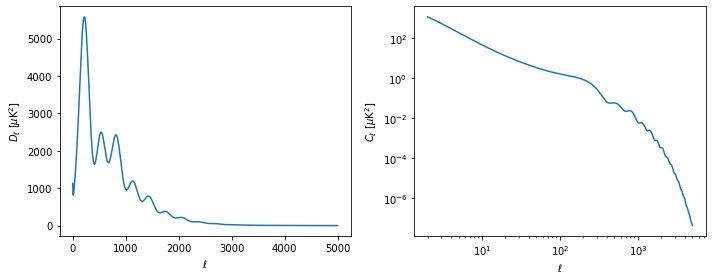

In [3]:
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalClsdat.sec", usecols=(0, 1), unpack=True)
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
# ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
# ClTT[1] = 0.

fig, axs = plt.subplots(1,2, figsize=(10,4))

# Plot 1
axs[0].plot(ell, DlTT)
axs[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
axs[0].set_xlabel('$\ell$')

# Plot 2
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
axs[1].loglog(ell, ClTT)
axs[1].set_ylabel('$C_{\ell}$ [$\mu$K$^2$]')
axs[1].set_xlabel('$\ell$')

plt.tight_layout()
#plt.savefig('cltt.png', dpi=300, bbox_inches='tight')
plt.show()


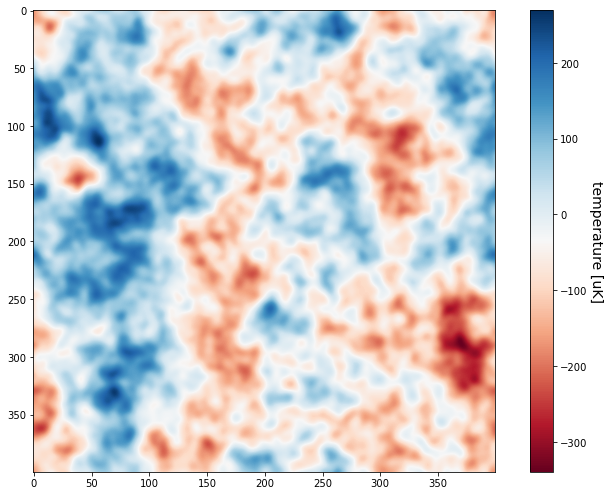

In [4]:
## create map array
map_size = 5.*60.   # map size in arcminutes
pix_size = 0.75    # pixel size in arcminutes
N = int(map_size/pix_size)  # dimension of the map array

## make a 2D array of X and Y coordinates
X,Y = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))

## define the radial coordinate R of each pixel. R is real-space counterpart of fourier variable k
R = np.sqrt(X**2. + Y**2.)

pix_to_rad = (pix_size/60. * np.pi/180.)   # this is the pixel size in radians
ell_scale_factor = np.pi /pix_to_rad    # here we connect angular size to the multipoles
ell2d = R * ell_scale_factor     # this is the Fourier analog of the real-vector R in 2D


## create 2D power spectrum
ClTT_expanded = np.zeros(int(ell2d.max())+1)
ClTT_expanded[0:(ClTT.size)] = ClTT  # fill in the Cls until the max of the ClTT vector
ClTT2d = ClTT_expanded[ell2d.astype(int)]

## make random realization of a Gaussian field and Fourier transform
random_array_for_T = np.random.normal(0,1,(N,N))
FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
FT_2d = np.sqrt(ClTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2

    
# move back from ell space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
# move back to pixel space for the map
CMB_T = CMB_T/pix_to_rad
# we only want to plot the real component
CMB_T = np.real(CMB_T)


## plot the CMB map
plt.figure(figsize=(10,7))
im = plt.imshow(CMB_T,cmap='RdBu', interpolation='bilinear')
cbar = plt.colorbar(im, orientation='vertical')
cbar.set_label('temperature [uK]', rotation=270, labelpad=15, fontsize=14)
plt.tight_layout()
#plt.savefig('realisticcmb_map.png', dpi=300, bbox_inches='tight')

plt.show()



0.003544394893165573

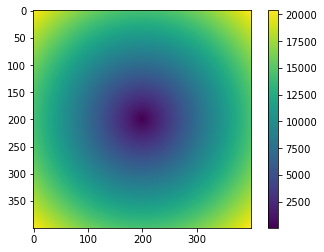

In [5]:
plt.imshow(ell2d)
plt.colorbar()
np.min(R)

In [6]:
#### parameters for setting up the spectrum
delta_ell = 50.
ell_max = 5000.

if max(ell)< ell_max:
        print('WARNING: Your theory curves end before the binned ell_max')

def calculate_2d_spectrum(Map1,Map2,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/40. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

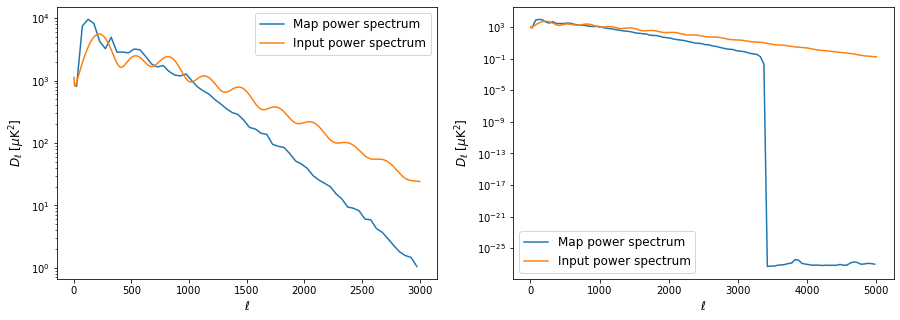

In [7]:
## make a power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(CMB_T,CMB_T,delta_ell,ell_max,pix_size,N)
#print binned_ell
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].semilogy(binned_ell[:60],(binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)[:60],label='Map power spectrum')
ax[0].semilogy(ell[:3000],DlTT[:3000],label='Input power spectrum')
ax[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
ax[0].set_xlabel('$\ell$',fontsize=12)
ax[0].legend(fontsize=12)
ax[1].semilogy(binned_ell,(binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi),label='Map power spectrum')
ax[1].semilogy(ell,DlTT,label='Input power spectrum')
ax[1].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
ax[1].set_xlabel('$\ell$',fontsize=12)
ax[1].legend(fontsize=12)
plt.show()

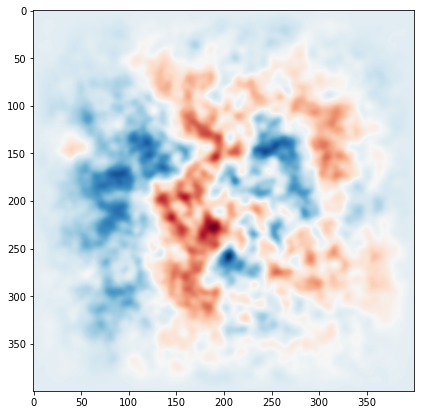

In [8]:
def cosine_window(N):
    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system
    N=int(N) 
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.)/N *np.pi ## eg runs from -pi/2 to pi/2
    X = np.outer(ones,inds)
    Y = np.transpose(X)
  
    # make a window map
    window_map = np.cos(X) * np.cos(Y)
   
    # return the window map
    return(window_map)
  ###############################
    
window = (cosine_window(N))
appodized_map = CMB_T * window
plt.figure(figsize=(10,7))
plt.imshow(appodized_map,cmap='RdBu', interpolation='bilinear')

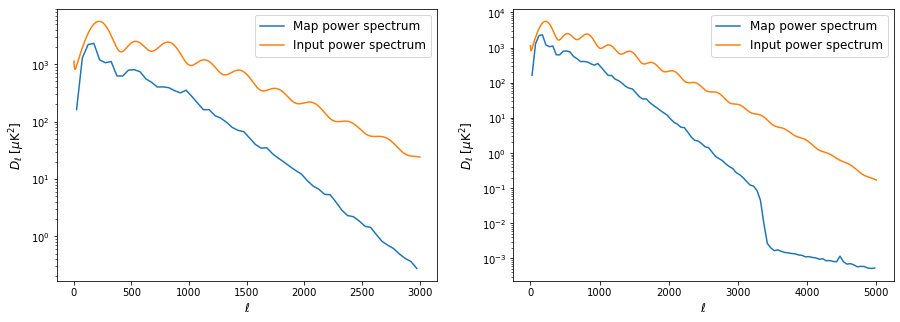

In [9]:
## make a power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)
#print binned_ell
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].semilogy(binned_ell[:60],(binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)[:60],label='Map power spectrum')
ax[0].semilogy(ell[:3000],DlTT[:3000],label='Input power spectrum')
ax[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
ax[0].set_xlabel('$\ell$',fontsize=12)
ax[0].legend(fontsize=12)
ax[1].semilogy(binned_ell,(binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi),label='Map power spectrum')
ax[1].semilogy(ell,DlTT,label='Input power spectrum')
ax[1].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
ax[1].set_xlabel('$\ell$',fontsize=12)
ax[1].legend(fontsize=12)
plt.show()

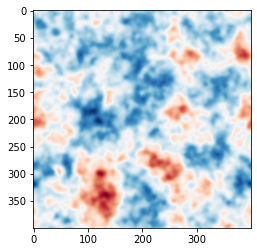

In [10]:
mlsol_w=np.load('map_ml_snw.npy')
mlsol_r=np.load('map_ml_snr.npy')
mlsol_ex=np.load('map_ml_snex.npy')
simulCMB=np.load('simulCMB.npy')

plt.imshow(simulCMB,cmap='RdBu', interpolation='bilinear')

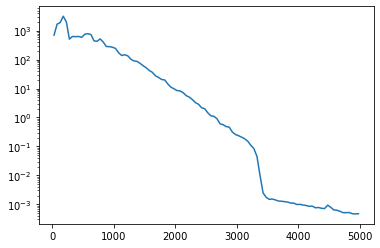

In [11]:
appo_simulCMB = simulCMB * window
bin_ell, bin_spectrum = calculate_2d_spectrum(appo_simulCMB,appo_simulCMB,delta_ell,ell_max,pix_size,N)
bin_ell, bin_spectrum=bin_ell,bin_spectrum
plt.semilogy(bin_ell,(bin_spectrum* bin_ell * (bin_ell+1.)/2. / np.pi),label='Map power spectrum')

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


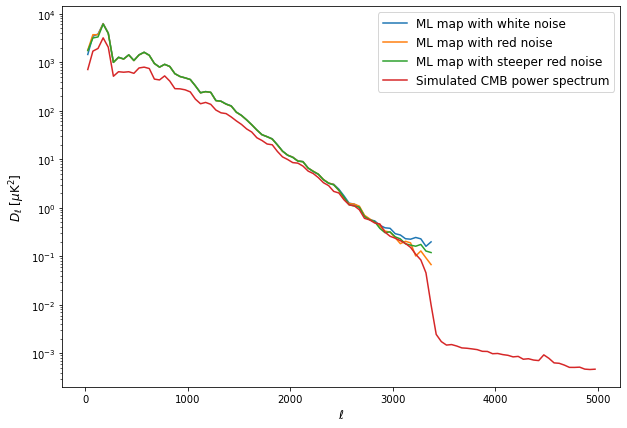

In [12]:
binning = 50
mlsol_w=cosine_window(100)*mlsol_w
mlsol_r=cosine_window(100)*mlsol_r
mlsol_ex=cosine_window(100)*mlsol_ex
binned_ell_w, binned_spectrum_w = calculate_2d_spectrum(mlsol_w,mlsol_w,binning,5000,3,100)
binned_ell_r, binned_spectrum_r = calculate_2d_spectrum(mlsol_r,mlsol_r,binning,5000,3,100)
binned_ell_ex, binned_spectrum_ex = calculate_2d_spectrum(mlsol_ex,mlsol_ex,binning,5000,3,100)
plt.figure(figsize=(10,7))
plt.semilogy(binned_ell_w,((binned_spectrum_w* binned_ell_w * (binned_ell_w+1.)/2. / np.pi)),label='ML map with white noise')
plt.semilogy(binned_ell_r,((binned_spectrum_r* binned_ell_r * (binned_ell_r+1.)/2. / np.pi)),label='ML map with red noise')
plt.semilogy(binned_ell_ex,((binned_spectrum_ex* binned_ell_ex * (binned_ell_ex+1.)/2. / np.pi)),label='ML map with steeper red noise')
plt.semilogy(bin_ell,(bin_spectrum* bin_ell * (bin_ell+1.)/2. / np.pi),label='Simulated CMB power spectrum')
#plt.semilogy(ell[:3000],DlTT[:3000],label='Input power spectrum')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
plt.xlabel('$\ell$',fontsize=12)
plt.legend(fontsize=12)

In [13]:
import pysm3
import pysm3.units as u
import healpy as hp


In [14]:
sky = pysm3.Sky(nside=2048, preset_strings=["c4"])  # one can choose the models. Documentation at https://pysm3.readthedocs.io/en/latest/models.html
sky.components

In [15]:
map_100GHz = sky.get_emission(100 * u.GHz)
map_100GHz = map_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz))


(50331648,)

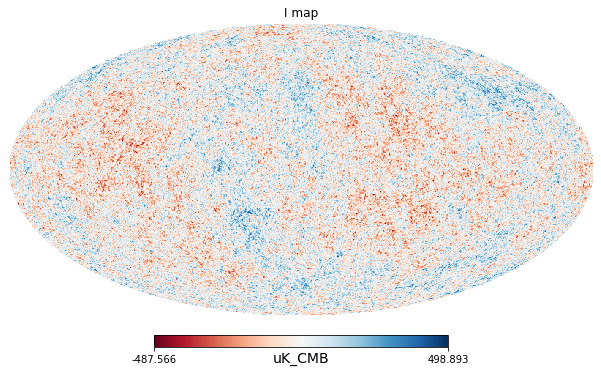

In [16]:
#hp.mollview(map_100GHz[0], min=-300 ,max=300, title="I map", unit=map_100GHz.unit,cmap='RdBu')
hp.mollview(map_100GHz[0],title="I map",unit=map_100GHz.unit,cmap='RdBu',remove_dip=True)
map_100GHz[0].shape



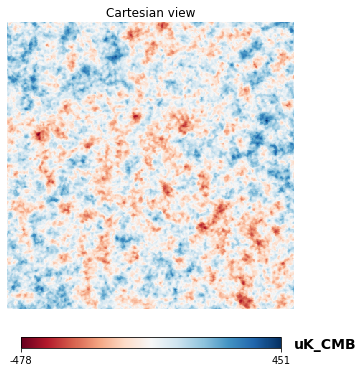

In [17]:
map=hp.visufunc.cartview(map_100GHz[0], unit=map_100GHz.unit, cmap='RdBu',lonra=[-10,10],latra=[-10,10],remove_dip=True,return_projected_map=True,xsize=400)
map=np.array(map)
#np.save('map.npy',map)

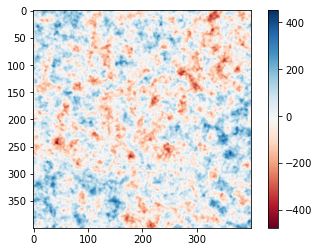

In [18]:
plt.imshow(map,cmap='RdBu', interpolation='bilinear')
plt.colorbar()
signalmap=np.concatenate([map.reshape(-1), map.T.reshape(-1)])
signalmap=np.array(signalmap)
#np.save('signalmap.npy',signalmap)


# Power Spectrum using anafast

Text(0, 0.5, '$C_{\\ell}$ [$\\mu$K$^2$]')

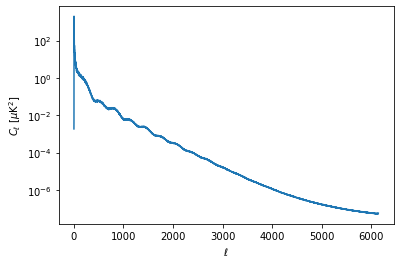

In [19]:
cl=hp.sphtfunc.anafast(map_100GHz[0], map_100GHz[0], alm=False)
plt.semilogy(np.arange(len(cl)),cl)
plt.xlabel('$\ell$')
plt.ylabel('$C_{\ell}$ [$\mu$K$^2$]')

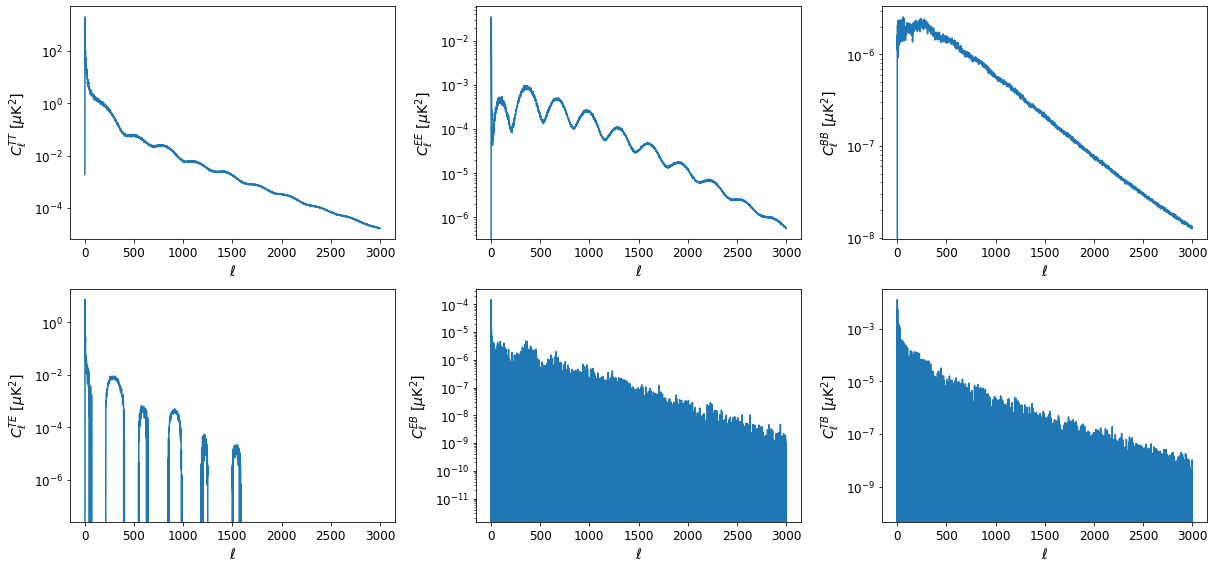

In [20]:
c_tt,c_ee,c_bb,c_te,c_eb,c_tb=hp.sphtfunc.anafast(map_100GHz, map_100GHz, alm=False,lmax=3000)

fig, ax = plt.subplots(2,3, figsize=(17,8))  # Changed to 2 rows and 3 columns
fontsize = 14
labelsize = 12

ax[0,0].semilogy(np.arange(len(c_tt)),c_tt)
ax[0,0].set_xlabel('$\ell$', fontsize=fontsize)
ax[0,0].set_ylabel('$C_{\ell}^{TT}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[0,0].tick_params(axis='both', which='major', labelsize=labelsize)

ax[0,1].semilogy(np.arange(len(c_ee)),c_ee)
ax[0,1].set_xlabel('$\ell$', fontsize=fontsize)
ax[0,1].set_ylabel('$C_{\ell}^{EE}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[0,1].tick_params(axis='both', which='major', labelsize=labelsize)

ax[0,2].semilogy(np.arange(len(c_bb)),c_bb)  # Moved to the third column of the first row
ax[0,2].set_xlabel('$\ell$', fontsize=fontsize)
ax[0,2].set_ylabel('$C_{\ell}^{BB}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[0,2].tick_params(axis='both', which='major', labelsize=labelsize)

ax[1,0].semilogy(np.arange(len(c_te)),c_te)  # Moved to the first column of the second row
ax[1,0].set_xlabel('$\ell$', fontsize=fontsize)
ax[1,0].set_ylabel('$C_{\ell}^{TE}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[1,0].tick_params(axis='both', which='major', labelsize=labelsize)

ax[1,1].semilogy(np.arange(len(c_eb)),c_eb)  # Moved to the second column of the second row
ax[1,1].set_xlabel('$\ell$', fontsize=fontsize)
ax[1,1].set_ylabel('$C_{\ell}^{EB}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[1,1].tick_params(axis='both', which='major', labelsize=labelsize)

ax[1,2].semilogy(np.arange(len(c_tb)),c_tb)  # Moved to the third column of the second row
ax[1,2].set_xlabel('$\ell$', fontsize=fontsize)
ax[1,2].set_ylabel('$C_{\ell}^{TB}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[1,2].tick_params(axis='both', which='major', labelsize=labelsize)

plt.tight_layout()


# using PySM3 maps and ML solver module

In [21]:
import solver as sr

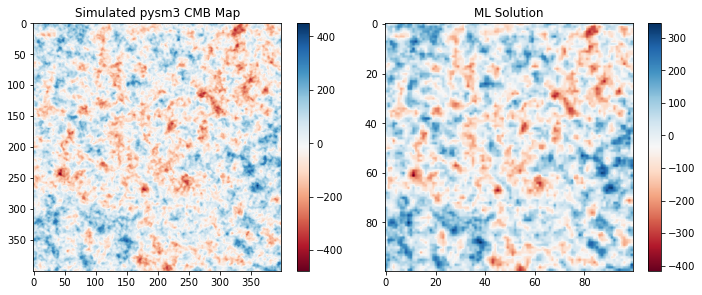

In [22]:
mlsol=sr.MLsolver(map)
ml_soln=mlsol.ml_solver(0)
#ml_soln=cosine_window(100)*mlsol.ml_solver(0)
#map=cosine_window(400)*map
plt.figure(figsize=(10,4))  # Adjust the size to accommodate both subplots

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.imshow(map, cmap='RdBu')
plt.colorbar()
plt.title('Simulated pysm3 CMB Map')

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.imshow(ml_soln, cmap='RdBu')
plt.colorbar()
plt.title('ML Solution')

plt.tight_layout()  # Optional: to prevent overlap of subplots

Text(0.5, 0, '$\\ell$')

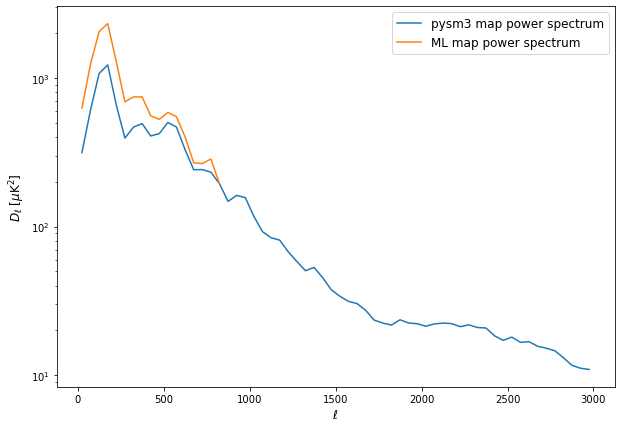

In [23]:
bin_ell_m, bin_spectrum_m = calculate_2d_spectrum(map,map,50,3000,3,400)
bin_ell, bin_spectrum = calculate_2d_spectrum(ml_soln,ml_soln,50,850,12,100)
plt.figure(figsize=(10,7))
plt.semilogy(bin_ell_m,(bin_spectrum_m* bin_ell_m * (bin_ell_m+1.)/2. / np.pi),label='pysm3 map power spectrum')
plt.semilogy(bin_ell,(bin_spectrum* bin_ell * (bin_ell+1.)/2. / np.pi),label='ML map power spectrum')
plt.legend(fontsize=12)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
plt.xlabel('$\ell$',fontsize=12)
